In [17]:
# Libraries
import pandas as pd
import numpy as np
import os
from plotnine import *
from mizani.formatters import custom_format

In [2]:
pd.set_option('display.max_columns', None)

path = '../0_data/collisions_data_2000_2022.csv'
df_collisions = pd.read_csv(path, low_memory = False)

In [3]:
# Filter the data to only contain the important features (from feature importance)
# accident_severity, junction_detail, junction_control, speed_limit
cols_save = ['accident_severity', 'junction_detail', 'junction_control', 'speed_limit']

df_collisions = df_collisions[cols_save]
df_collisions.shape

(3691651, 4)

In [4]:
# Dictionary for renaming the important features (junction detail and road type)

accident_severity_dict = { 
    1: 'Fatal', 2: 'Serious', 3: 'Slight'
    }
junction_detail_dict = {
    0: 'Not Jct', 1: 'Roundabout', 2: 'Roundabout', 3: 'T/Staggered Jct', 5: 'Slip Rd', 6: 'Crossroads', 
    7: 'Multi-Arm Jct', 8: 'Priv Entr', 9: 'Other Jct', 99: 'Unknown', -1: 'Unknown'
    }
junction_control_dict = {
    0: 'Not Jct', 1: 'Auth. Person', 2: 'Traffic Signal', 3: 'Stop Sign', 4: 'Give Way/Unctrl', 
    -1: 'Unknown', 9: 'Unknown'
    }

# Dictionary of dictionaries for renaming
rename_dict = {
    'accident_severity': accident_severity_dict,
    'junction_detail' : junction_detail_dict,
    'junction_control' : junction_control_dict
}

# Loop through the dictionary to rename values
for column, mapping_dict in rename_dict.items():
    if column in df_collisions.columns: 
        df_collisions[column] = df_collisions[column].replace(mapping_dict)
        if column != 'accident_severity':
            df_collisions[column] = df_collisions[column].astype('category')

In [5]:
# Bin the speed limits into 'unknown', 'under_20', '20-29', '30-39', '40-49', '50-59', '60-69', '70_or_more'
bin_edges = [-np.inf, -1, 19, 29, 39, 49, 59, 69, np.inf]
bin_labels = ['Unknown', 'Under 20', '20', '30', '40', '50', '60', '70 Or Over']
df_collisions['binned_speed_limit'] = pd.cut(df_collisions['speed_limit'], bins = bin_edges, labels = bin_labels, include_lowest = True)

In [6]:
df_collisions.head()

,accident_severity,junction_detail,junction_control,speed_limit,binned_speed_limit
0,Slight,Not Jct,Unknown,70.0,70 Or Over
1,Slight,Roundabout,Give Way/Unctrl,70.0,70 Or Over
2,Slight,Not Jct,Unknown,60.0,60
3,Slight,Not Jct,Unknown,70.0,70 Or Over
4,Slight,Slip Rd,Give Way/Unctrl,70.0,70 Or Over


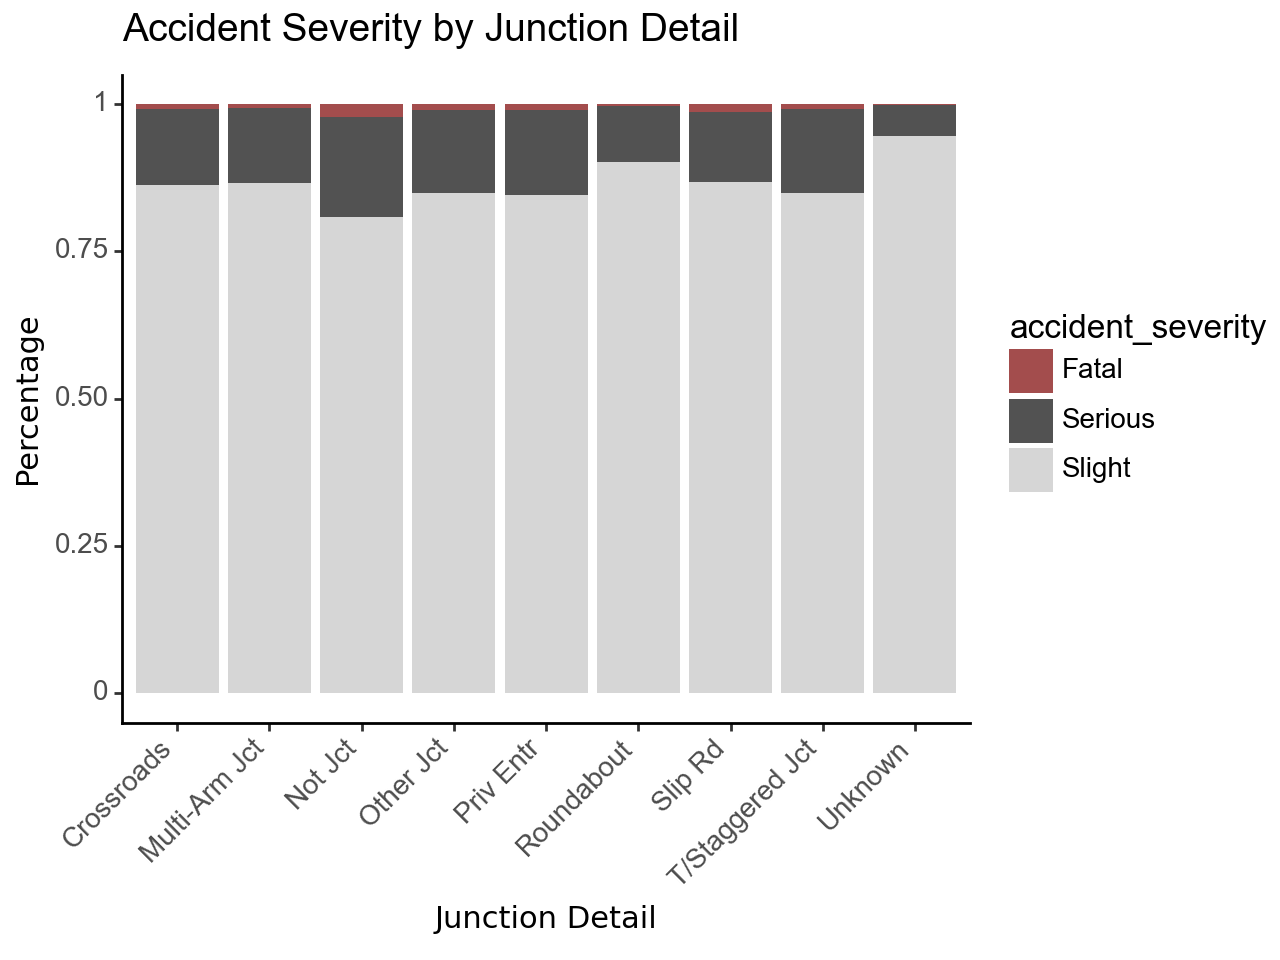

In [9]:
# Ensure accident_severity is a categorical variable
#df_collisions['accident_severity'] = df_collisions['accident_severity'].astype('category')

# Calculate the count of each accident severity within each junction detail
df_grouped = df_collisions.groupby(['junction_detail', 'accident_severity']).size().reset_index(name='count')

# Calculate the total count for each junction detail
total_counts = df_grouped.groupby('junction_detail')['count'].transform('sum')

# Calculate the percentage
df_grouped['percentage'] = df_grouped['count'] / total_counts * 100

# Plot
plot = (
    ggplot(df_grouped, aes(x='junction_detail', y='percentage', fill='accident_severity')) +
    geom_bar(stat='identity', position='fill') +  # Use position='fill' for 100% stacked bars
    scale_fill_manual(values=["#A34D4D", "#525252", "#D6D6D6"]) +  # Specify your colors here
    labs(y="Percentage", x="Junction Detail", title="Accident Severity by Junction Detail") +
    theme_classic() +
    theme(
        axis_text_x=element_text(angle=45, hjust=1, size=10, family="Arial"),
        axis_text_y=element_text(size=10, family="Arial"),
        plot_title=element_text(size=14, family="Arial"),
        legend_title=element_text(size=12, family="Arial"),
        legend_text=element_text(size=10, family="Arial")
    )
)

print(plot)



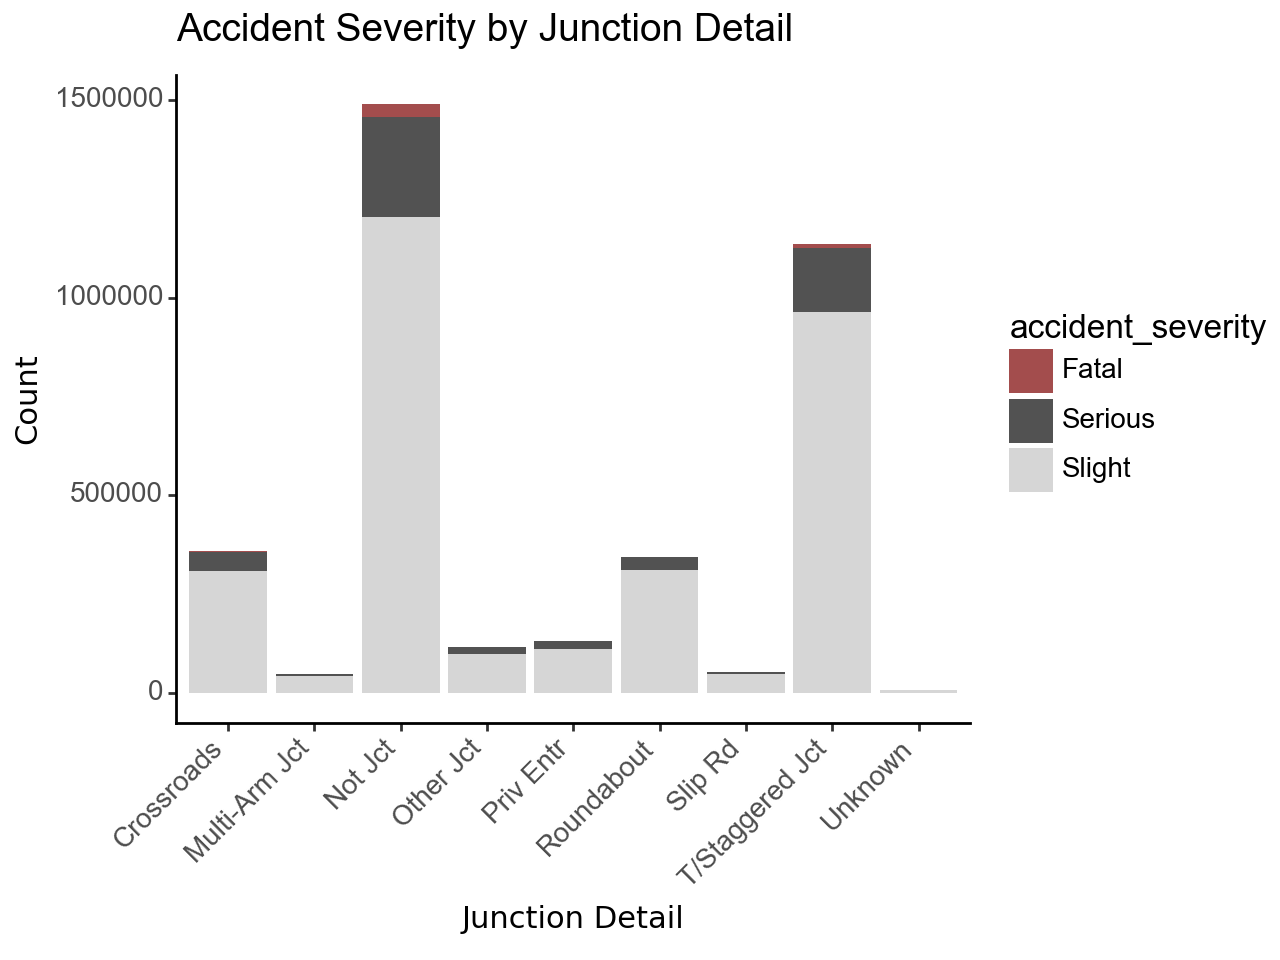

In [10]:
# Ensure accident_severity is a categorical variable
df_collisions['accident_severity'] = df_collisions['accident_severity'].astype('category')

# Calculate the count of each accident severity within each junction detail
df_grouped = df_collisions.groupby(['junction_detail', 'accident_severity']).size().reset_index(name='count')

# Plot
plot = (
    ggplot(df_grouped, aes(x='junction_detail', y='count', fill='accident_severity')) +
    geom_bar(stat='identity', position='stack') +  # Stacked bar plot
    scale_fill_manual(values=["#A34D4D", "#525252", "#D6D6D6"]) +  # Specify your colors here
    labs(y="Count", x="Junction Detail", title="Accident Severity by Junction Detail") +
    theme_classic() +
    theme(
        axis_text_x=element_text(angle=45, hjust=1, size=10, family="Arial"),
        axis_text_y=element_text(size=10, family="Arial"),
        plot_title=element_text(size=14, family="Arial"),
        legend_title=element_text(size=12, family="Arial"),
        legend_text=element_text(size=10, family="Arial")
    )
)

print(plot)


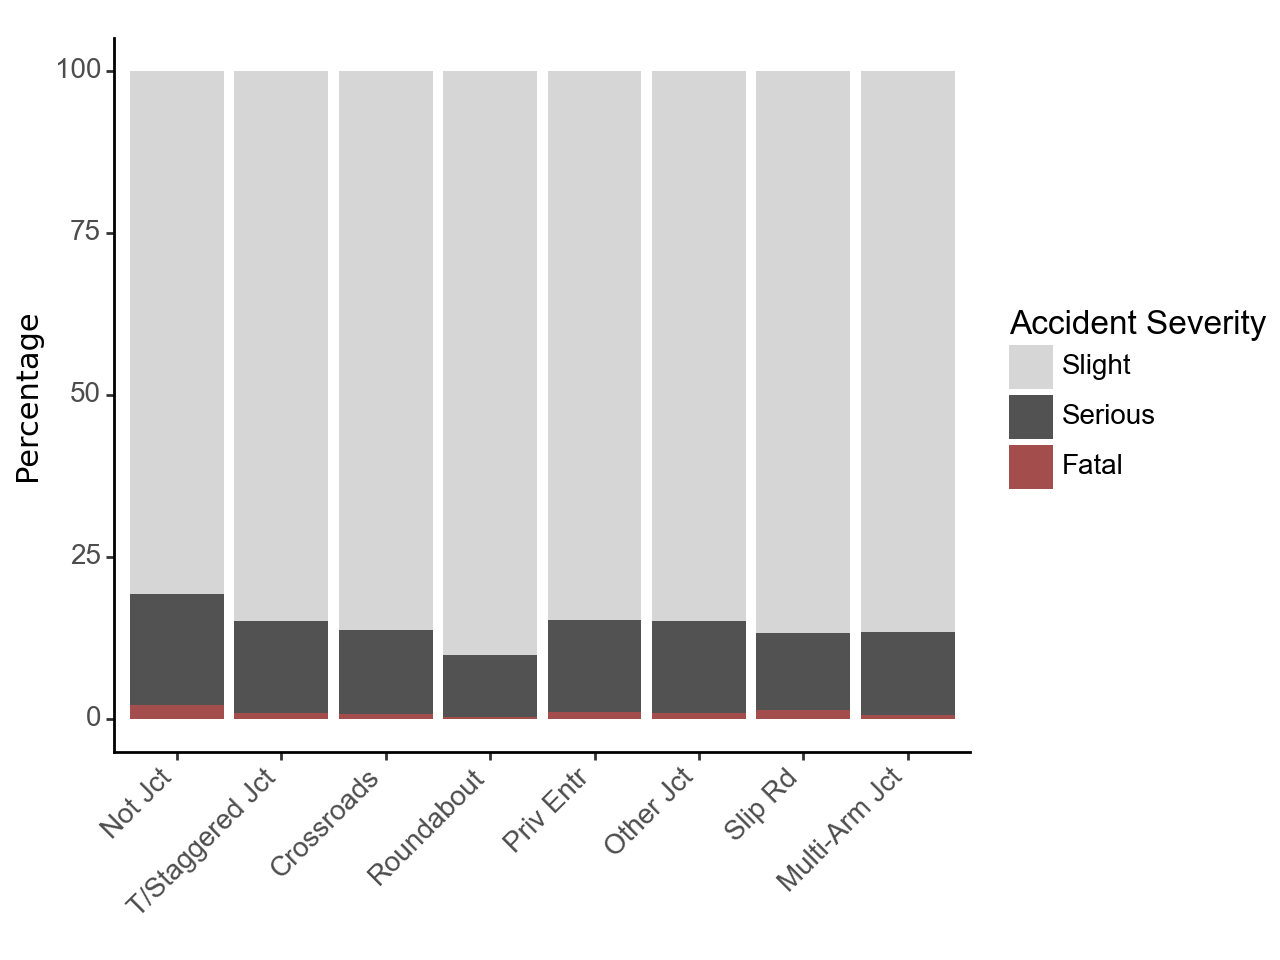

In [12]:
# Sorted based on the number of accidents for the junction detail

# Ensure accident_severity is a categorical variable
df_collisions['accident_severity'] = df_collisions['accident_severity'].astype('category')

# Calculate the count of each accident severity within each junction detail
df_grouped = df_collisions.groupby(['junction_detail', 'accident_severity']).size().reset_index(name='count')

# Remove unknown values
df_grouped = df_grouped.loc[~(df_grouped.isin(['Unknown']).any(axis=1))]

# Calculate the total count for each junction detail
total_counts = df_grouped.groupby('junction_detail')['count'].transform('sum')

# Calculate the percentage
df_grouped['percentage'] = df_grouped['count'] / total_counts * 100

# Reverse the Order of Stacking
df_grouped['accident_severity'] = pd.Categorical(df_grouped['accident_severity'], categories=reversed(df_grouped['accident_severity'].cat.categories))

# Plot
plot = (
    ggplot(df_grouped, aes(x='reorder(junction_detail, -count)', y='percentage', fill='accident_severity')) +
    geom_bar(stat='identity', position='stack') +  # Stacked bar plot
    scale_fill_manual(values=["#D6D6D6", "#525252", "#A34D4D"]) +  # Specify your colors here
    labs(y="Percentage", x="", fill="Accident Severity", title="") +
    theme_classic() +
    theme(
        axis_text_x=element_text(angle=45, hjust=1, size=10, family="Arial"),
        axis_text_y=element_text(size=10, family="Arial"),
        plot_title=element_text(size=14, family="Arial"),
        legend_title=element_text(size=12, family="Arial"),
        legend_text=element_text(size=10, family="Arial"),
        legend_position='right'
    )
)

print(plot)

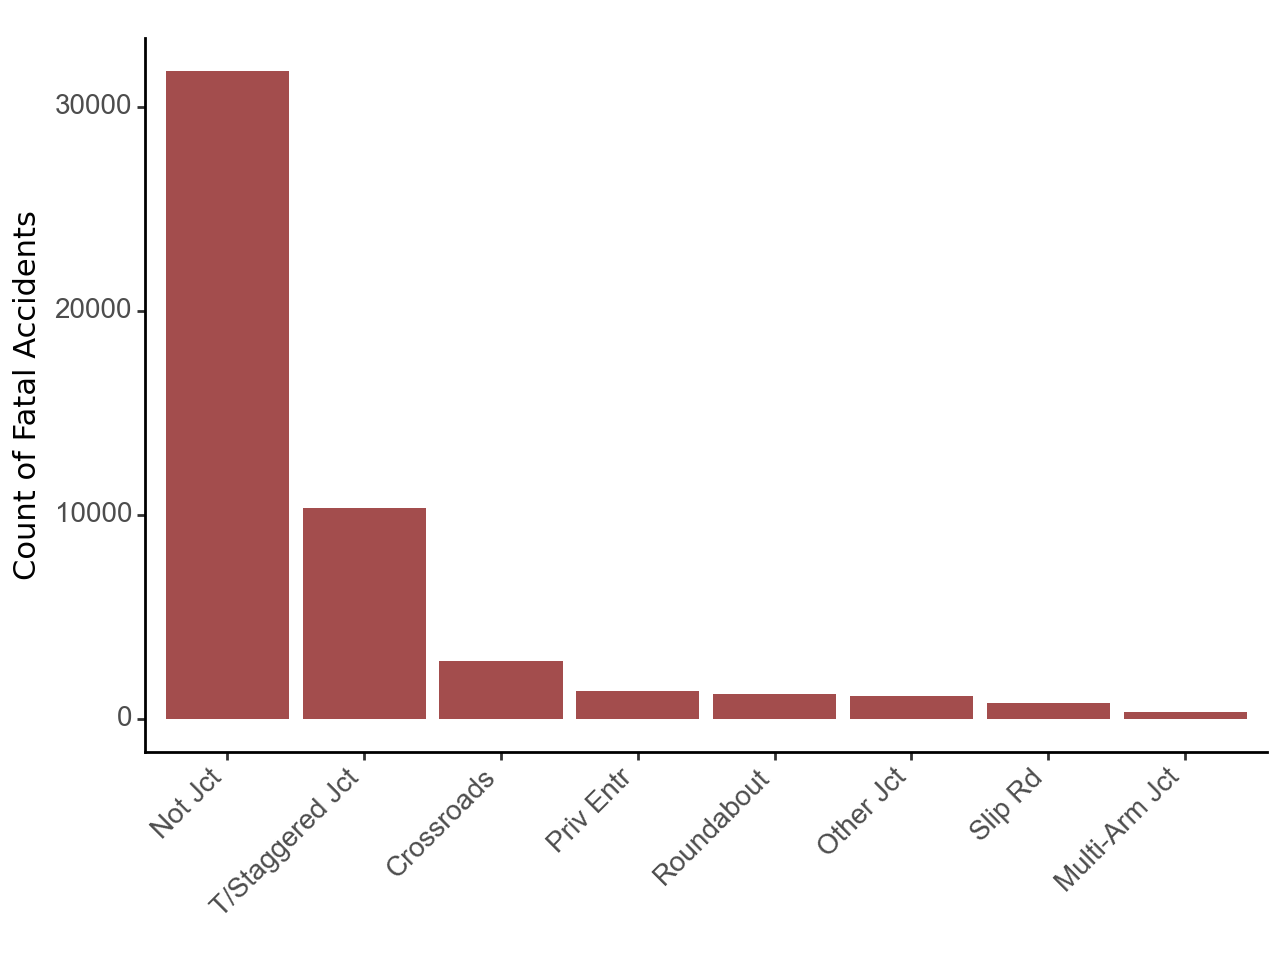

In [27]:
# Filter for only fatal accidents
df_fatal = df_collisions[df_collisions['accident_severity'] == 'Fatal']

# Calculate the count of fatal accidents for each junction detail
df_fatal_grouped = df_fatal.groupby('junction_detail').size().reset_index(name='count')

# Remove unknown values
df_fatal_grouped = df_fatal_grouped.loc[~(df_fatal_grouped.isin(['Unknown']).any(axis=1))]

# Plot
plot = (
    ggplot(df_fatal_grouped, aes(x='reorder(junction_detail, -count)', y='count')) +
    geom_bar(stat='identity', position='dodge', fill="#A34D4D") +
    labs(y="Count of Fatal Accidents", x="", title="") +
    theme_classic() +
    theme(
        axis_text_x=element_text(angle=45, hjust=1, size=10, family="Arial"),
        axis_text_y=element_text(size=10, family="Arial"),
        plot_title=element_text(size=14, family="Arial"),
        legend_position='none'
    )
)

print(plot)

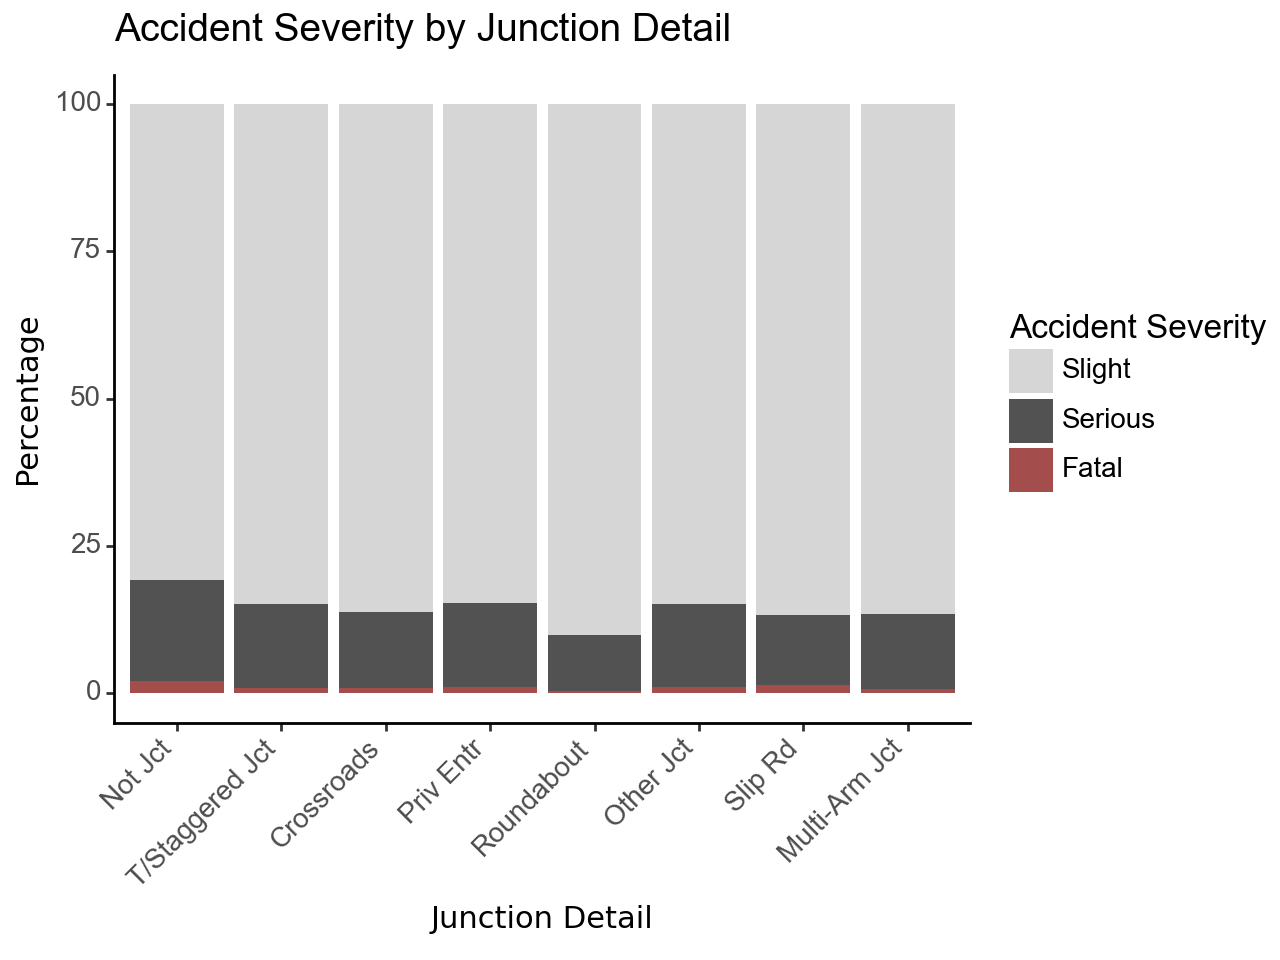

In [14]:
# Sorted based on number of fatal accidents

# Filter for only fatal accidents
df_fatal = df_collisions[df_collisions['accident_severity'] == 'Fatal']

# Calculate the count of fatal accidents for each junction detail
df_fatal_counts = df_fatal.groupby('junction_detail').size().reset_index(name='fatal_count')

# Remove 'Unknown' values from both datasets
df_fatal_counts = df_fatal_counts[df_fatal_counts['junction_detail'] != 'Unknown']
df_collisions = df_collisions[df_collisions['junction_detail'] != 'Unknown']

# Ensure accident_severity is a categorical variable
df_collisions['accident_severity'] = df_collisions['accident_severity'].astype('category')

# Calculate the count of each accident severity within each junction detail
df_grouped = df_collisions.groupby(['junction_detail', 'accident_severity']).size().reset_index(name='count')

# Calculate the total count for each junction detail
total_counts = df_grouped.groupby('junction_detail')['count'].transform('sum')

# Calculate the percentage
df_grouped['percentage'] = df_grouped['count'] / total_counts * 100

# Merge with fatal counts for ordering
df_grouped = df_grouped.merge(df_fatal_counts, on='junction_detail')

# Reverse the Order of Stacking
df_grouped['accident_severity'] = pd.Categorical(df_grouped['accident_severity'], categories=reversed(df_grouped['accident_severity'].cat.categories))

# Plot
plot = (
    ggplot(df_grouped, aes(x='reorder(junction_detail, -fatal_count)', y='percentage', fill='accident_severity')) +
    geom_bar(stat='identity', position='stack') +  # Stacked bar plot
    scale_fill_manual(values=["#D6D6D6", "#525252", "#A34D4D"]) +  # Specify your colors here
    labs(y="Percentage", x="Junction Detail", fill="Accident Severity", title="Accident Severity by Junction Detail") +
    theme_classic() +
    theme(
        axis_text_x=element_text(angle=45, hjust=1, size=10, family="Arial"),
        axis_text_y=element_text(size=10, family="Arial"),
        plot_title=element_text(size=14, family="Arial"),
        legend_title=element_text(size=12, family="Arial"),
        legend_text=element_text(size=10, family="Arial"),
        legend_position='right'
    )
)

print(plot)


c:\Users\loma5202\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


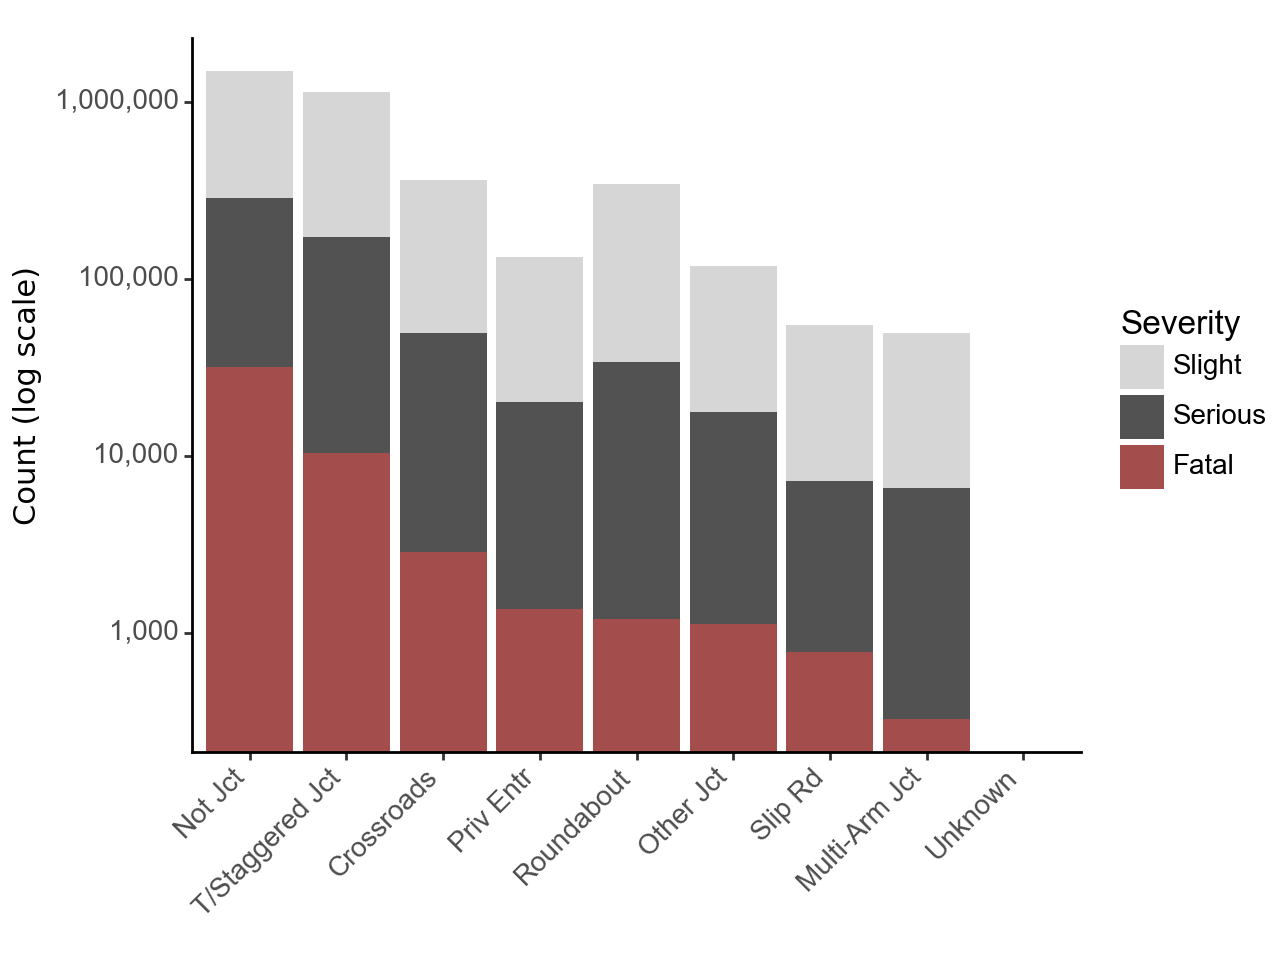

In [19]:
# Filter for only fatal accidents
df_fatal = df_collisions[df_collisions['accident_severity'] == 'Fatal']

# Calculate the count of fatal accidents for each junction detail
df_fatal_counts = df_fatal.groupby('junction_detail').size().reset_index(name='fatal_count')

# Remove 'Unknown' values
df_grouped = df_collisions[df_collisions['junction_detail'] != 'Unknown']

# Ensure accident_severity is a categorical variable
df_grouped['accident_severity'] = df_grouped['accident_severity'].astype('category')

# Calculate the count of each accident severity within each junction detail
df_grouped = df_grouped.groupby(['junction_detail', 'accident_severity']).size().reset_index(name='count')

# Merge with fatal counts for ordering
df_grouped = df_grouped.merge(df_fatal_counts, on='junction_detail')

# Reverse the Order of Stacking
df_grouped['accident_severity'] = pd.Categorical(df_grouped['accident_severity'], categories=reversed(df_grouped['accident_severity'].cat.categories))

# Plot
plot = (
    ggplot(df_grouped, aes(x='reorder(junction_detail, -fatal_count)', y='count', fill='accident_severity')) +
    geom_bar(stat='identity', position='stack') +  # Stacked bar plot
    scale_y_continuous(labels=custom_format('{:,.0f}'), trans='log10') +  # Non-scientific format for y-axis
    scale_fill_manual(values=["#D6D6D6", "#525252", "#A34D4D"]) +  # Specify your colors here
    labs(y="Count (log scale)", x="", fill="Severity", title="") +
    theme_classic() +
    theme(
        axis_text_x=element_text(angle=45, hjust=1, size=10, family="Arial"),
        axis_text_y=element_text(size=10, family="Arial"),
        plot_title=element_text(size=14, family="Arial"),
        legend_title=element_text(size=12, family="Arial"),
        legend_text=element_text(size=10, family="Arial"),
        legend_position='right'
    )
)

print(plot)
